# Instalation of the needed Modules

Instalation of the Counterfactual from Jürgen

In [1]:
!git clone https://github.com/facebookresearch/mmd.git

Cloning into 'mmd'...
remote: Enumerating objects: 45, done.
remote: Counting objects: 100% (45/45), done.
remote: Compressing objects: 100% (38/38), done.
remote: Total 45 (delta 5), reused 38 (delta 4), pack-reused 0
Receiving objects: 100% (45/45), 884.64 KiB | 6.32 MiB/s, done.
Resolving deltas: 100% (5/5), done.


Installation of Kaggle importer

In [2]:
!pip install -q kaggle

# Import of the modules

Import des Os Modules

In [3]:
import os

Import of Colab addon Modules

In [4]:
from google.colab import files

Import of Tabular funcion

In [5]:
!git clone https://github.com/FrancisBurger/Tabular_Counterfactual

Cloning into 'Tabular_Counterfactual'...
remote: Enumerating objects: 6, done.
remote: Counting objects: 100% (6/6), done.
remote: Compressing objects: 100% (5/5), done.
remote: Total 6 (delta 0), reused 0 (delta 0), pack-reused 0
Receiving objects: 100% (6/6), 8.69 KiB | 1.74 MiB/s, done.


In [6]:
from Tabular_Counterfactual import tabular_counterfactual

Import of numpy, pandas and the pyplot modules

In [7]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

Import of Tensorflow Modules

In [8]:
import tensorflow as tf
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers.experimental.preprocessing import Normalization
from tensorflow.keras.models import Sequential

Import of Sklearn Modules

In [9]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

Import of Counterfactual Modules

In [10]:
from mmd.counterfactuals.explainer import SequenceExplainer
from mmd.counterfactuals.counterfactual_search import GreedySearch

# Import Dataset

Import of kaggle usage token

In [11]:
uploaded = files.upload()

Saving kaggle.json to kaggle.json


Creating a directory to store the uploaded Token

In [12]:
! mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json

Download the Datasets from Kaggle

## Training dataset

In [13]:
! kaggle datasets download -d inIT-OWL/vega-shrinkwrapper-runtofailure-data

  0% 0.00/411k [00:00<?, ?B/s]
100% 411k/411k [00:00<00:00, 75.7MB/s]


## Dataset for exploration

In [14]:
! kaggle datasets download -d inIT-OWL/one-year-industrial-component-degradation
! mkdir ~/runtofailure-data
! mkdir ~/component-degradation
! unzip vega-shrinkwrapper-runtofailure-data -d runtofailure-data
! unzip one-year-industrial-component-degradation -d component-degradation

 88% 67.0M/75.8M [00:00<00:00, 120MB/s] 
100% 75.8M/75.8M [00:00<00:00, 99.4MB/s]
Archive:  vega-shrinkwrapper-runtofailure-data.zip
  inflating: runtofailure-data/NewBlade001.csv  
  inflating: runtofailure-data/NewBlade002.csv  
  inflating: runtofailure-data/NewBlade003.csv  
  inflating: runtofailure-data/WornBlade001.csv  
  inflating: runtofailure-data/WornBlade002.csv  
  inflating: runtofailure-data/WornBlade003.csv  
Archive:  one-year-industrial-component-degradation.zip
  inflating: component-degradation/01-04T184148_000_mode1.csv  
  inflating: component-degradation/01-04T184424_001_mode1.csv  
  inflating: component-degradation/01-04T184835_002_mode1.csv  
  inflating: component-degradation/01-04T185047_003_mode1.csv  
  inflating: component-degradation/01-04T185257_004_mode1.csv  
  inflating: component-degradation/01-05T123134_005_mode1.csv  
  inflating: component-degradation/01-05T133345_006_mode1.csv  
  inflating: component-degradation/01-05T133550_007_mode1.csv  
  

Converting Data to DataFrame

Adding the Training Dataset

In [15]:
NewBlade001_df = pd.read_csv("/content/runtofailure-data/NewBlade001.csv")
NewBlade002_df = pd.read_csv("/content/runtofailure-data/NewBlade002.csv")
NewBlade003_df = pd.read_csv("/content/runtofailure-data/NewBlade003.csv")
WornBlade001_df = pd.read_csv("/content/runtofailure-data/WornBlade001.csv")
WornBlade002_df = pd.read_csv("/content/runtofailure-data/WornBlade002.csv")
WornBlade003_df = pd.read_csv("/content/runtofailure-data/WornBlade003.csv")

Adding the Degradation Dataset

In [16]:
DIRECTORY_PATH_OLD = "/content/component-degradation"
directory_files_old = os.listdir(DIRECTORY_PATH_OLD)
directory_files_old.remove("oneyeardata")

In [17]:
%%time
master_df = pd.DataFrame()
for file_name in directory_files_old:
    temp_path = DIRECTORY_PATH_OLD + "/" + file_name
    baby_df = pd.read_csv(temp_path)
    master_df = pd.concat([master_df, baby_df], ignore_index=True)

CPU times: user 7.87 s, sys: 2.11 s, total: 9.98 s
Wall time: 10.5 s


# Describing the dataset

## Introduction

> **Kaggle Described**: "The Vega shrink-wrapper from OCME is deployed in large production lines in the food and beverage industry. The machine groups loose bottles or cans into set package sizes, wraps them in plastic film and then heat-shrinks the plastic film to combine them into a package. The plastic film is fed into the machine from large spools and is then cut to the length needed to wrap the film around a pack of goods. The cutting assembly is an important component of the machine to meet the high availability target. Therefore, the blade needs to be set-up and maintained properly. Furthermore, the blade can not be inspected visually during operation due to the blade being enclosed in a metal housing and its fast rotation speed. Monitoring the cutting blades degradation will increase the machines reliability and reduce unexpected downtime caused by failed cuts".

The 2 images will illustrate the **Shrink-Wrapper** system in a 3-D pencil drawing, the cutting unit within the system, and the mechanism of blade. [[Source](https://www.kaggle.com/code/anshumoudgil/iiot-or-industry-4-0-shrink-wrapper-concept)]


### System's concept

**Image 1**: <span style="color:mediumblue">**Schneider Electric US'** Packaging's Parcelling Machine drawing.</span>


This image (*a representative image*) is shown to describe the whole phenomenon of **Shrink Wrapping**, and it is in quite close proximity to **OCME's VegaHT's Shrink-Wrap** system.


<center>


![Parcelling Machine drawing](https://www.se.com/us/en/assets/739/media/41499/1200/Parceling-IC-900x500.jpg)


</center>


Source: **Schneider Electric US'** Packaging's Parceling Machine drawing.


**Image 2**: <span style="color:mediumblue">**Cutting Unit** is one of the sub-sections of **OCME's VegaHT's Shrink-Wrapper**.</span>


It houses the **Cutting Blade**, a mechanical piece that is the <span style="color:red">**raison d’être**</span> for this notebook’s data.


<center>


![VegaHT Cutting Unit](http://improve-vfof.eu/fileadmin/improve/images/case_studies/VegaHT_CuttingUnit.png)


</center>


Source: **OCME VegaHT Cutting Unit** & IMPROVE virtual Factories of Future


The film cutting and in-feed system is one of the primary components of OCME machines. It is extremely reliable over time, thanks to the combined action of blade and counter-blade that does not require complicated adjustments and the system that ensures accurate cutting speed controls through a brushless motor drive.


<span style="color:mediumblue">**Cutting Blade Design** and **Blade in action** between rollers.</span>


About the image on **Left Hand Side**: The film cutting and winding system is one of the two fundamental components of shrink wrappers. OCME has adopted an extremely reliable film-cutting technology, thanks to the combined action of blade and counter-blade. The objective is to cut the film cleanly and precisely at the required speed, always repeating the operation at the desired point, especially when pre-printed films are used.


About the image on **Right Hand Side**: In the OCME film cutting system, the blades do **not** come into contact with other mechanical parts, ensuring long service life and cutting precision.


Source: **RMIT Industry** [*Kyiv, Ukraine*]. [[Source](https://www.kaggle.com/code/anshumoudgil/iiot-or-industry-4-0-shrink-wrapper-concept)]

### Blade's Functioning

Depending on the speed, Vega adopts different cut command systems.


- **Speeds up to 60 cycles per minute** an electromagnetic clutch is used to activate cutting. The device controls the movement of the blade and counter-blade, which, in order to reduce stress and wear on the mechanism, are fitted on the elliptical pinions to ensure the smooth movement of the cutting cycle (low initial speed, acceleration during cutting, and deceleration at the end of the cycle).

- **Speeds over 60 cycles per minute** the cutting device is pulled by a brushless motor fitted on a mobile tower positioned at the optimal point of the ramp based on film length and machine speed. The mobile tower supporting the cutting device is positioned by a servomotor at the low-speed film unwinding point. This enables cutting at the lowest speed point of the film. [[Source](https://www.kaggle.com/code/anshumoudgil/iiot-or-industry-4-0-shrink-wrapper-concept)]

## Data Sets

There are 6 data sets divided into **2 sets of blades**, **New Blades** & **Worn Blades** with **3 pieces each**, and they show records of intricate play of various mechanical parts and actions housed in the cutting unit of OCME’s VegaHT. Each data set has 8 features (*variables*) and 2048 observations (*tuples*); besides, their columns’ names are also the same. Features have been described below (*as given on Kaggle*):

1. Timestamp - Timestamp (seconds)
2. pCut Motor Torque - Torque (nM)

<span style="color:tomato"> *The force that causes **Anti-Clock Wise** rotation is **Positive Torque**, and the force that causes **Clock Wise** rotation is **Negative Torque**.*</span>

3. pCut CTRL Position controller Lag error - Represent the instantaneous position error between the set-point from the path generator and the real current encoder position of the motor.
4. pCut CTRL Position controller Actual position - Cutting Blade Position (mm).
5. pCut CTRL Position controller Actual speed - Speed of the cutting blade.
6. pSvolFilm CTRL Position controller Actual position: Plastic film unwinder position (mm).
7. pSvolFilm CTRL Position controller Actual speed - Speed of the Plastic Film Unwinder.
8. pSvolFilm CTRL Position controller Lag error - Represent the instantaneous position error between the set-point from the path generator and the real current encoder position of the motor.

[[Source](https://www.kaggle.com/code/anshumoudgil/iiot-or-industry-4-0-shrink-wrapper-concept)]

## Adding some target values, aka adding colum for describing the data.
"New Blades" refers to a target as 0.

"Worn Blades" refers to a target as 1.

In [18]:
NewBlade001_df["Target"] = 0
NewBlade002_df["Target"] = 0
NewBlade003_df["Target"] = 0
WornBlade001_df["Target"] = 1
WornBlade002_df["Target"] = 1
WornBlade003_df["Target"] = 1

Merge all the data.

In [19]:
newData = pd.concat([NewBlade001_df, NewBlade002_df, NewBlade003_df], ignore_index=True)

In [20]:
wornData = pd.concat(
    [WornBlade001_df, WornBlade002_df, WornBlade003_df], ignore_index=True
)

In [21]:
newWornData = pd.concat([newData, wornData], ignore_index=True)

General settings for plots

In [22]:
plt.style.use("grayscale")

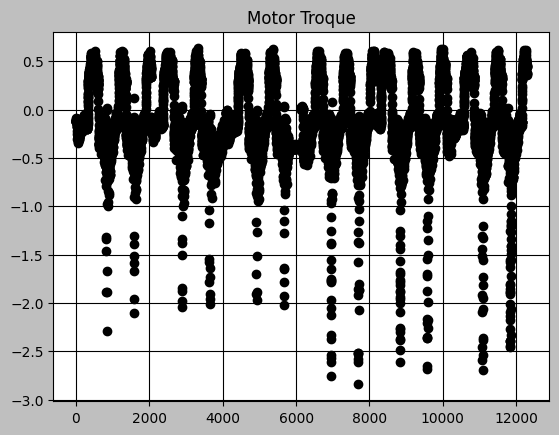

In [23]:
newWornData["pCut Motor: Torque"]
plt.scatter(
    range(len(newWornData["pCut Motor: Torque"])), newWornData["pCut Motor: Torque"]
)
plt.title("Motor Troque")
plt.grid()
plt.savefig("/content/drive/MyDrive/1 Projects/#BacArbeit/fig/Motor_torque.png")
plt.show()

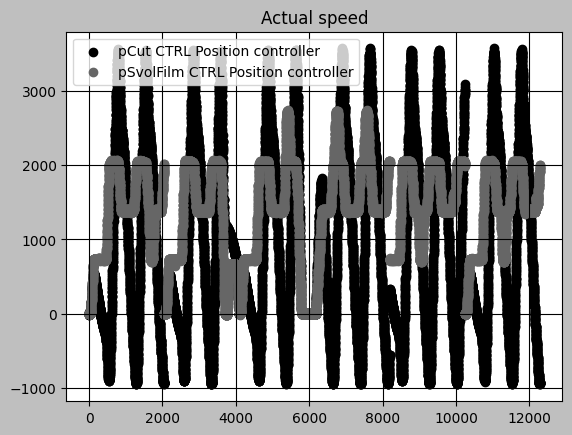

In [24]:
plt.scatter(
    range(len(newWornData[" pCut CTRL Position controller: Actual speed"])),
    newWornData[" pCut CTRL Position controller: Actual speed"],
)
plt.scatter(
    range(len(newWornData[" pSvolFilm CTRL Position controller: Actual speed"])),
    newWornData[" pSvolFilm CTRL Position controller: Actual speed"],
)
plt.title("Actual speed")
plt.legend(["pCut CTRL Position controller", "pSvolFilm CTRL Position controller"])
plt.grid()
plt.savefig("/content/drive/MyDrive/1 Projects/#BacArbeit/fig/acual_speed.png")
plt.show()

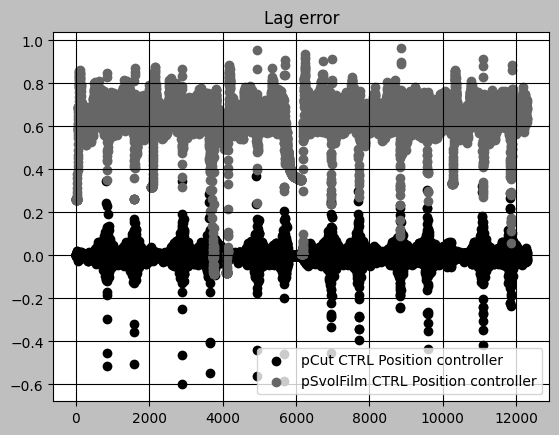

In [25]:
plt.scatter(
    range(len(newWornData[" pCut CTRL Position controller: Lag error"])),
    newWornData[" pCut CTRL Position controller: Lag error"],
)
plt.scatter(
    range(len(newWornData[" pSvolFilm CTRL Position controller: Lag error"])),
    newWornData[" pSvolFilm CTRL Position controller: Lag error"],
)
plt.title("Lag error")
plt.legend(
    ["pCut CTRL Position controller", "pSvolFilm CTRL Position controller"],
    loc="lower right",
)
plt.grid()
plt.savefig("/content/drive/MyDrive/1 Projects/#BacArbeit/fig/lag_error.png")
plt.show()

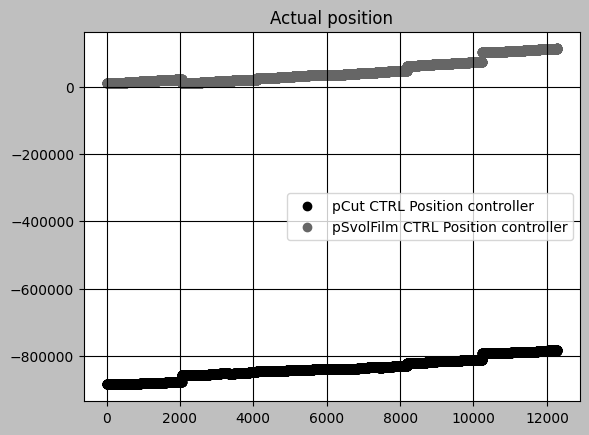

In [26]:
plt.scatter(
    range(len(newWornData[" pCut CTRL Position controller: Actual position"])),
    newWornData[" pCut CTRL Position controller: Actual position"],
)
plt.scatter(
    range(len(newWornData[" pSvolFilm CTRL Position controller: Actual position"])),
    newWornData[" pSvolFilm CTRL Position controller: Actual position"],
)
plt.title("Actual position")
plt.legend(["pCut CTRL Position controller", "pSvolFilm CTRL Position controller"])
plt.grid()
plt.savefig("/content/drive/MyDrive/1 Projects/#BacArbeit/fig/actual_position.png")
plt.show()

# Split dataset into test and train dataset

In [27]:
X = newWornData.drop(columns=["Target", "Timestamp"], axis=1)
y = newWornData["Target"]
X_np = X.to_numpy()
y_np = y.to_numpy()

In [28]:
FeatureNames = X.columns.to_list()

In [29]:
for ind in FeatureNames:
    print(ind)

pCut Motor: Torque
 pCut CTRL Position controller: Lag error
 pCut CTRL Position controller: Actual position
 pCut CTRL Position controller: Actual speed
 pSvolFilm CTRL Position controller: Actual position
 pSvolFilm CTRL Position controller: Actual speed
 pSvolFilm CTRL Position controller: Lag error


In [30]:
X_train, X_test, y_train, y_test = train_test_split(
    X_np, y_np, test_size=0.2, random_state=21
)

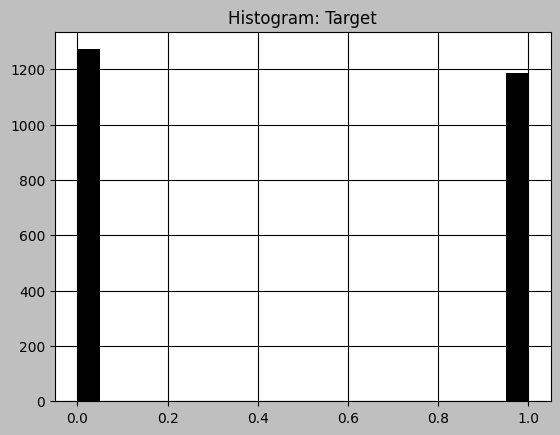

In [31]:
plt.hist(y_test, bins=20)
plt.title("Histogram: Target")
plt.grid()
plt.savefig("/content/drive/MyDrive/1 Projects/#BacArbeit/fig/hist_target.png")
plt.show()

# Create an ML System
Use Orru2020 as a reference.

The random generators' seeds are set in order to ensure that the results are able to be repeated.

In [32]:
# np.random.seed(739)
# tf.random.set_seed(1033)
tf.keras.utils.set_random_seed(
    127
)

In [33]:
%%time
clas_model = Sequential()
norm_layer = Normalization()
norm_layer.adapt(X_train)
clas_model.add(norm_layer)
clas_model.add(Dense(10, activation="relu"))
clas_model.add(Dense(10, activation="relu"))
clas_model.add(Dense(1, activation="sigmoid"))

CPU times: user 777 ms, sys: 36 ms, total: 813 ms
Wall time: 1.07 s


In [34]:
clas_model.compile(
    optimizer="sgd",
    loss="binary_crossentropy",
    metrics=["accuracy", tf.keras.metrics.FalseNegatives()],
)

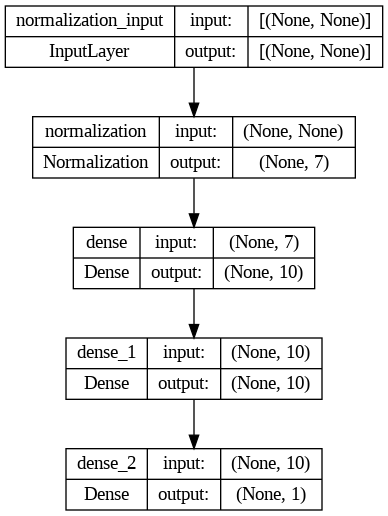

In [35]:
tf.keras.utils.plot_model(clas_model, show_shapes=True)

# Train ML on the dataset

In [36]:
%%time
clas_model.fit(
    X_train, y_train, epochs=20, validation_split=0.1, validation_data=(X_test, y_test)
)

Epoch 1/20
308/308 [==============================] - 2s 3ms/step - loss: 0.6018 - accuracy: 0.7198 - false_negatives: 1388.0000 - val_loss: 0.4851 - val_accuracy: 0.8194 - val_false_negatives: 171.0000
Epoch 2/20
308/308 [==============================] - 1s 3ms/step - loss: 0.3705 - accuracy: 0.8772 - false_negatives: 691.0000 - val_loss: 0.2890 - val_accuracy: 0.8959 - val_false_negatives: 170.0000
Epoch 3/20
308/308 [==============================] - 1s 3ms/step - loss: 0.2244 - accuracy: 0.9199 - false_negatives: 549.0000 - val_loss: 0.1906 - val_accuracy: 0.9284 - val_false_negatives: 113.0000
Epoch 4/20
308/308 [==============================] - 1s 3ms/step - loss: 0.1544 - accuracy: 0.9459 - false_negatives: 362.0000 - val_loss: 0.1397 - val_accuracy: 0.9434 - val_false_negatives: 87.0000
Epoch 5/20
308/308 [==============================] - 1s 3ms/step - loss: 0.1153 - accuracy: 0.9553 - false_negatives: 298.0000 - val_loss: 0.1088 - val_accuracy: 0.9585 - val_false_negatives:

In [37]:
clas_model

In [38]:
print(clas_model.history.history.keys())

dict_keys(['loss', 'accuracy', 'false_negatives', 'val_loss', 'val_accuracy', 'val_false_negatives'])


## Plots of Training History

In [39]:
hist_acc = clas_model.history.history["accuracy"]
hist_val_acc = clas_model.history.history["val_accuracy"]
hist_loss = clas_model.history.history["loss"]
hist_val_loss = clas_model.history.history["val_loss"]
hist_false = clas_model.history.history["false_negatives"]
hist_val_false = clas_model.history.history["val_false_negatives"]

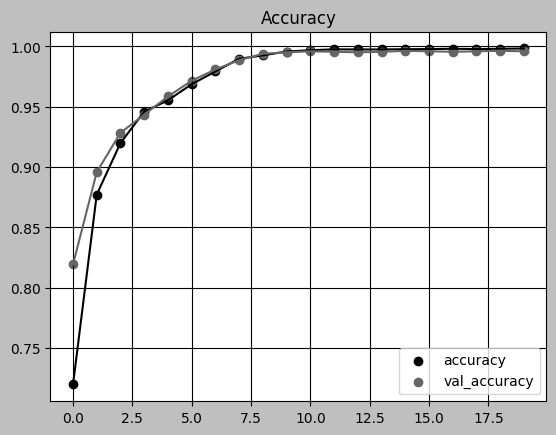

In [40]:
plt.scatter(range(len(hist_acc)), hist_acc)
plt.scatter(range(len(hist_val_acc)), hist_val_acc)
plt.plot(hist_acc)
plt.plot(hist_val_acc)
plt.title("Accuracy")
plt.legend(["accuracy", "val_accuracy"])
plt.grid()
plt.savefig("/content/drive/MyDrive/1 Projects/#BacArbeit/fig/ml_accur.png")
plt.show()

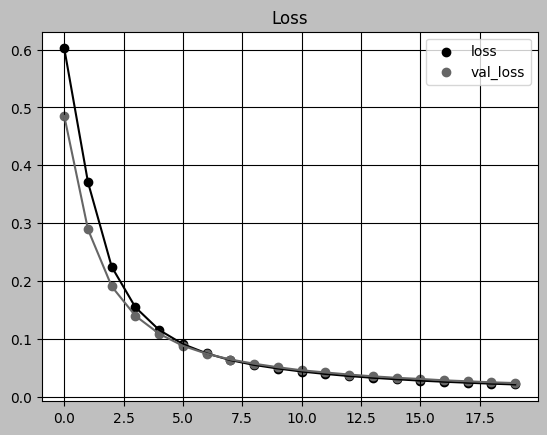

In [41]:
plt.scatter(range(len(hist_loss)), hist_loss)
plt.scatter(range(len(hist_val_loss)), hist_val_loss)
plt.plot(hist_loss)
plt.plot(hist_val_loss)
plt.title("Loss")
plt.legend(["loss", "val_loss"])
plt.grid()
plt.savefig("/content/drive/MyDrive/1 Projects/#BacArbeit/fig/ml_loss.png")
plt.show()

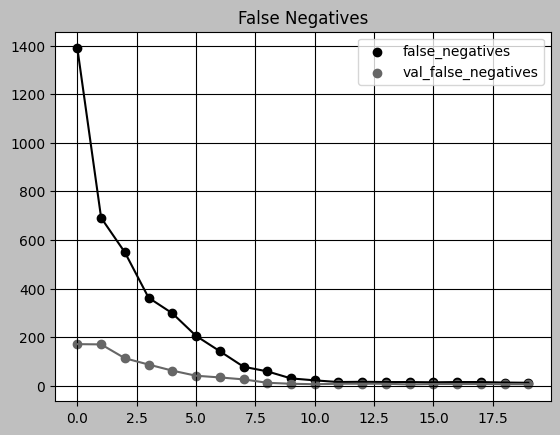

In [42]:
plt.scatter(range(len(hist_false)), hist_false)
plt.scatter(range(len(hist_val_false)), hist_val_false)
plt.plot(hist_false)
plt.plot(hist_val_false)
plt.title("False Negatives")
plt.legend(["false_negatives", "val_false_negatives"])
plt.grid()
plt.savefig("/content/drive/MyDrive/1 Projects/#BacArbeit/fig/ml_false_neg.png")
plt.show()

## Checkup of the Model

In [43]:
pred_dnn = clas_model.predict(X_test)

77/77 [==============================] - 0s 2ms/step


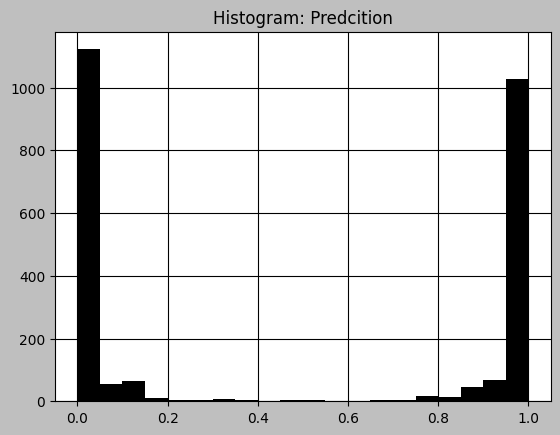

In [44]:
plt.hist(pred_dnn, bins=20)
plt.title("Histogram: Predcition")
plt.grid()
plt.savefig("/content/drive/MyDrive/1 Projects/#BacArbeit/fig/hist_pred.png")
plt.show()

## Certitude score of the training dataset

In [45]:
certit_scr = np.absolute(pred_dnn - 0.5) * 2.0

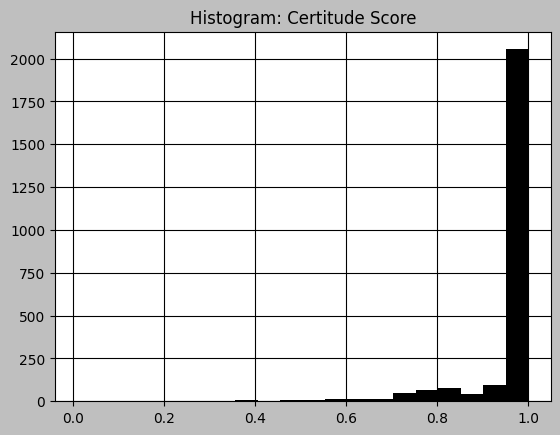

In [46]:
plt.hist(certit_scr, bins=20)
plt.title("Histogram: Certitude Score")
plt.grid()
plt.savefig("/content/drive/MyDrive/1 Projects/#BacArbeit/fig/hist_score.png")
plt.show()

## Confusion Matrix

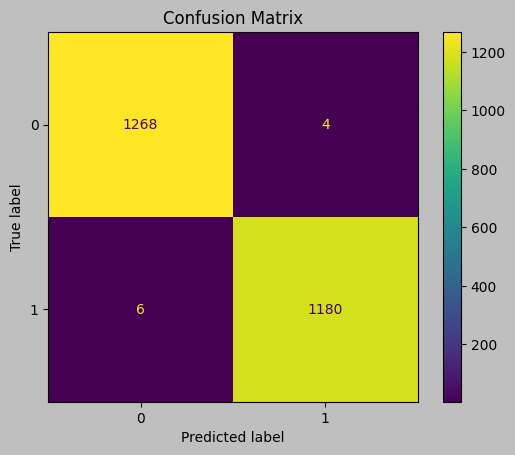

In [47]:
y_pred_max = np.round(pred_dnn, 0)
cm = confusion_matrix(y_test, y_pred_max, labels=np.array([0, 1]))
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=np.array([0, 1]))
disp.plot()
plt.title("Confusion Matrix")
plt.savefig("/content/drive/MyDrive/1 Projects/#BacArbeit/fig/confusion_matrix.png")
plt.show()

Investigating the degradation dataset

In [48]:
X_master_df = master_df.drop(columns=["timestamp", "pSpintor::VAX_speed"], axis=1)

In [49]:
X_master_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1062912 entries, 0 to 1062911
Data columns (total 7 columns):
 #   Column                                                Non-Null Count    Dtype  
---  ------                                                --------------    -----  
 0   pCut::Motor_Torque                                    1062912 non-null  float64
 1   pCut::CTRL_Position_controller::Lag_error             1062912 non-null  float64
 2   pCut::CTRL_Position_controller::Actual_position       1062912 non-null  int64  
 3   pCut::CTRL_Position_controller::Actual_speed          1062912 non-null  float64
 4   pSvolFilm::CTRL_Position_controller::Actual_position  1062912 non-null  int64  
 5   pSvolFilm::CTRL_Position_controller::Actual_speed     1062912 non-null  float64
 6   pSvolFilm::CTRL_Position_controller::Lag_error        1062912 non-null  float64
dtypes: float64(5), int64(2)
memory usage: 56.8 MB


Transforation of the DataFrame to a Numpy Array

In [50]:
X_master_np = X_master_df.to_numpy()

# Pedict the states with the model

In [51]:
%%time
pred_master = clas_model.predict(X_master_np)

33216/33216 [==============================] - 54s 2ms/step
CPU times: user 1min 11s, sys: 2.98 s, total: 1min 14s
Wall time: 1min 22s


# Plotting the predicted states

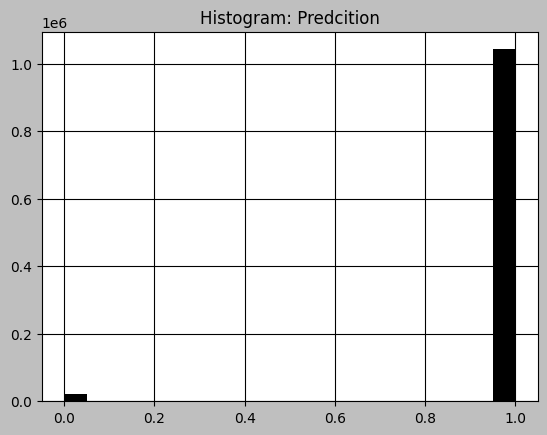

In [52]:
plt.hist(pred_master, bins=20)
plt.title("Histogram: Predcition")
plt.grid()
plt.savefig("/content/drive/MyDrive/1 Projects/#BacArbeit/fig/hist_pred_one_year.png")
plt.show()

# Add Prediciton and Label to the Dataset

## Incorporation of the Prediciton and Label
Rounding the predicted value for the label and taking the prediction.

In [53]:
X_master_df["Predicion"] = pred_master
X_master_df["Label"] = np.round(pred_master, 0)

## Add the Certitude score to the dataset.
Implementing a weighting algorithm so the score is mapped to another plane
A round of predictions for labels.

In [54]:
X_master_df["Certitude Score"] = pd.DataFrame.abs(X_master_df["Predicion"] - 0.5) * 2.0

# Stripping off "Sharp blades" of the dataset
Dividing the dataset into "new" and "worn" blades.
Both new datasets can be used for counterfactual exploration.
The "new Blades" dataset is generating likeable visualisations.

In [55]:
X_master_worn_df = X_master_df[X_master_df["Label"] == 1]

In [56]:
X_master_new_df = X_master_df[X_master_df["Label"] == 0]

## Checkup the new created dataset

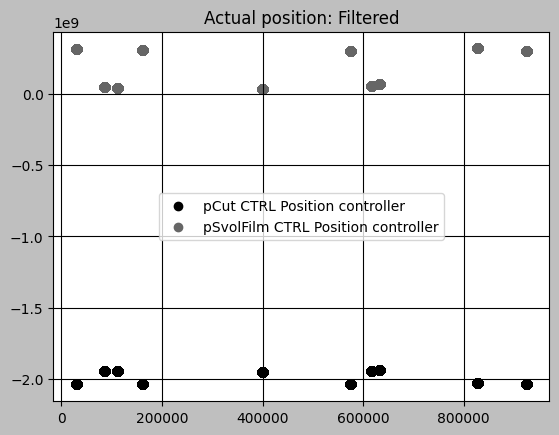

In [57]:
plt.scatter(
    X_master_new_df.index,
    X_master_new_df["pCut::CTRL_Position_controller::Actual_position"],
)
plt.scatter(
    X_master_new_df.index,
    X_master_new_df["pSvolFilm::CTRL_Position_controller::Actual_position"],
)
plt.title("Actual position: Filtered")
plt.legend(
    ["pCut CTRL Position controller", "pSvolFilm CTRL Position controller"],
    loc="center",
)
plt.grid()
plt.savefig("/content/drive/MyDrive/1 Projects/#BacArbeit/fig/pred_act_pos.png")
plt.show()

# Comparison of Datasets
from training datasets to predicted values

In [58]:
# range of the droped dataset
range_drop = 6144

In [59]:
X_master_new_drop_df = X_master_new_df.reset_index()
X_master_new_drop_df = X_master_new_drop_df[0:range_drop]

In [60]:
X_master_worn_drop_df = X_master_worn_df.reset_index()
X_master_worn_drop_df = X_master_worn_drop_df[0:range_drop]

## Motor Torque: New

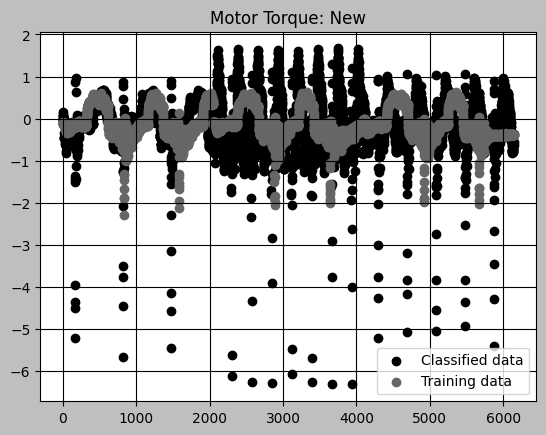

In [61]:
plt.scatter(X_master_new_drop_df.index, X_master_new_drop_df["pCut::Motor_Torque"])
plt.scatter(newData.index, newData["pCut Motor: Torque"])
plt.title("Motor Torque: New")
plt.legend(["Classified data", "Training data"])
plt.grid()
plt.savefig("/content/drive/MyDrive/1 Projects/#BacArbeit/fig/Motor_Torque_New.png")
plt.show()

## Motor Torque: Worn

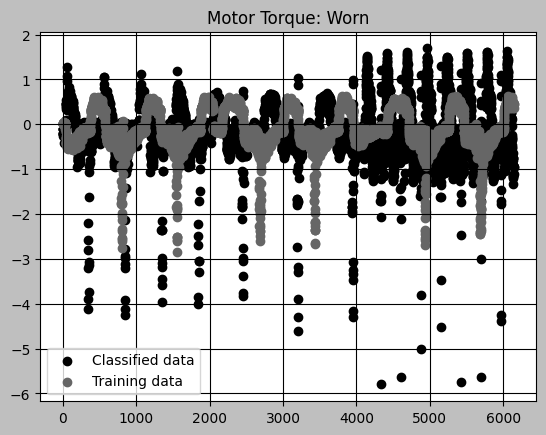

In [62]:
plt.scatter(X_master_worn_drop_df.index, X_master_worn_drop_df["pCut::Motor_Torque"])
plt.scatter(wornData.index, wornData["pCut Motor: Torque"])
plt.title("Motor Torque: Worn")
plt.legend(["Classified data", "Training data"])
plt.grid()
plt.savefig("/content/drive/MyDrive/1 Projects/#BacArbeit/fig/Motor_Torque_Worn.png")
plt.show()

## pCut, Lag error: New

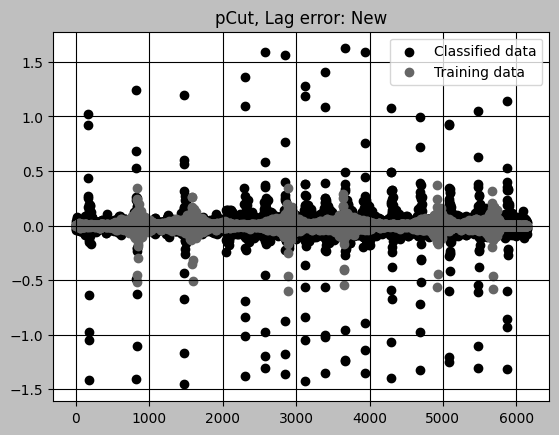

In [63]:
plt.scatter(
    X_master_new_drop_df.index,
    X_master_new_drop_df["pCut::CTRL_Position_controller::Lag_error"],
)
plt.scatter(
    newData.index,
    newData[" pCut CTRL Position controller: Lag error"],
)
plt.title("pCut, Lag error: New")
plt.legend(["Classified data", "Training data"])
plt.grid()
plt.savefig("/content/drive/MyDrive/1 Projects/#BacArbeit/fig/pCut_Lag_error_New.png")
plt.show()

## pCut, Lag error: Worn

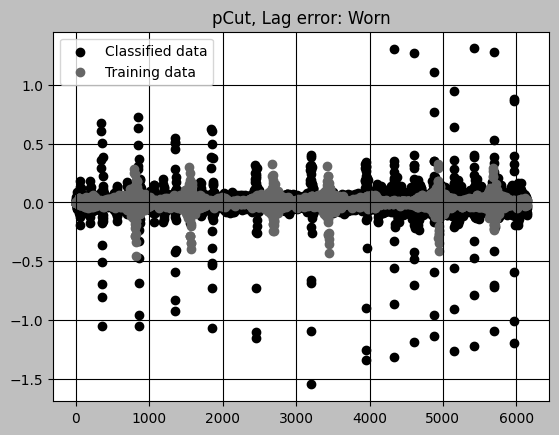

In [64]:
plt.scatter(
    X_master_worn_drop_df.index,
    X_master_worn_drop_df["pCut::CTRL_Position_controller::Lag_error"],
)
plt.scatter(
    wornData.index,
    wornData[" pCut CTRL Position controller: Lag error"],
)
plt.title("pCut, Lag error: Worn")
plt.legend(["Classified data", "Training data"])
plt.grid()
plt.savefig("/content/drive/MyDrive/1 Projects/#BacArbeit/fig/pCut_Lag_error_Worn.png")
plt.show()

## pCut, Actual position: New

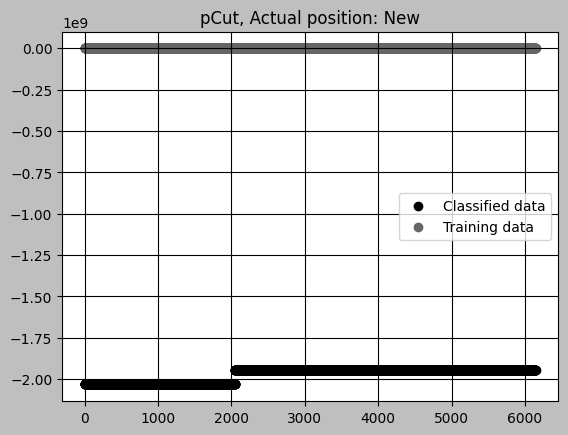

In [65]:
plt.scatter(
    X_master_new_drop_df.index,
    X_master_new_drop_df["pCut::CTRL_Position_controller::Actual_position"],
)
plt.scatter(newData.index, newData[" pCut CTRL Position controller: Actual position"])
plt.title("pCut, Actual position: New")
plt.legend(["Classified data", "Training data"])
plt.grid()
plt.savefig(
    "/content/drive/MyDrive/1 Projects/#BacArbeit/fig/pCut_Actual_position_New.png"
)
plt.show()

## pCut, Actual position: Worn

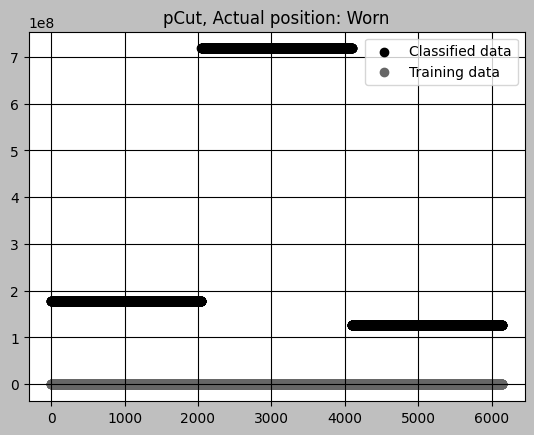

In [66]:
plt.scatter(
    X_master_worn_drop_df.index,
    X_master_worn_drop_df["pCut::CTRL_Position_controller::Actual_position"],
)
plt.scatter(
    wornData.index, wornData[" pCut CTRL Position controller: Actual position"]
)
plt.title("pCut, Actual position: Worn")
plt.legend(["Classified data", "Training data"])
plt.grid()
plt.savefig(
    "/content/drive/MyDrive/1 Projects/#BacArbeit/fig/pCut_Actual_position_Worn.png"
)
plt.show()

## pCut, Actual speed: New

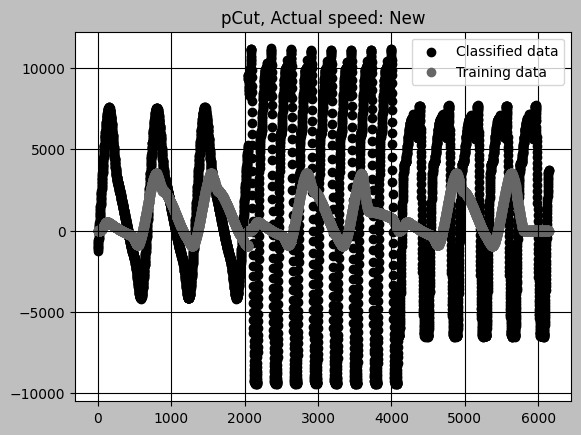

In [67]:
plt.scatter(
    X_master_new_drop_df.index,
    X_master_new_drop_df["pCut::CTRL_Position_controller::Actual_speed"],
)
plt.scatter(
    newData.index,
    newData[" pCut CTRL Position controller: Actual speed"],
)
plt.title("pCut, Actual speed: New")
plt.legend(["Classified data", "Training data"])
plt.grid()
plt.savefig(
    "/content/drive/MyDrive/1 Projects/#BacArbeit/fig/pCut_Actual_speed_New.png"
)
plt.show()

## pCut, Actual speed: Worn

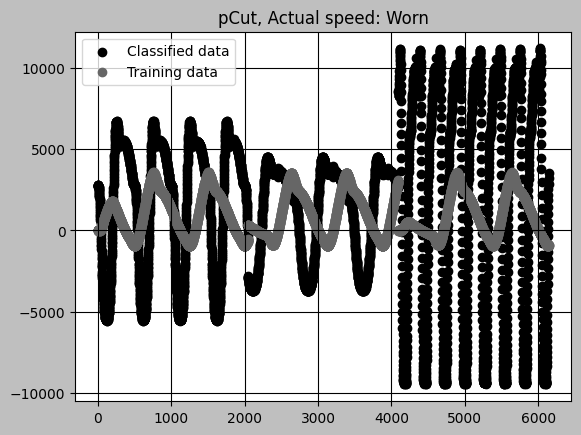

In [68]:
plt.scatter(
    X_master_worn_drop_df.index,
    X_master_worn_drop_df["pCut::CTRL_Position_controller::Actual_speed"],
)
plt.scatter(
    wornData.index,
    wornData[" pCut CTRL Position controller: Actual speed"],
)
plt.title("pCut, Actual speed: Worn")
plt.legend(["Classified data", "Training data"])
plt.grid()
plt.savefig(
    "/content/drive/MyDrive/1 Projects/#BacArbeit/fig/pCut_Actual_speed_Worn.png"
)
plt.show()

## pSvolFilm, Actual position: New"

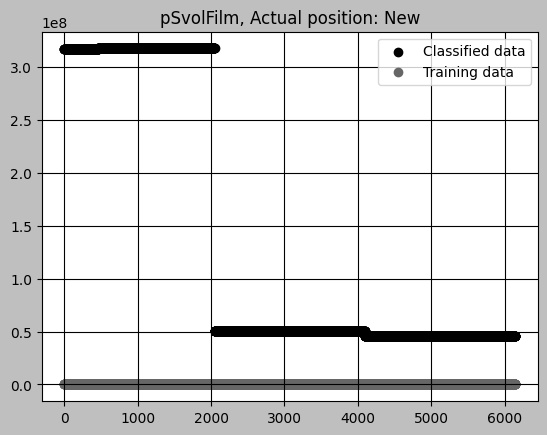

In [69]:
plt.scatter(
    X_master_new_drop_df.index,
    X_master_new_drop_df["pSvolFilm::CTRL_Position_controller::Actual_position"],
)
plt.scatter(
    newData.index, newData[" pSvolFilm CTRL Position controller: Actual position"]
)
plt.title("pSvolFilm, Actual position: New")
plt.legend(["Classified data", "Training data"])
plt.grid()
plt.savefig(
    "/content/drive/MyDrive/1 Projects/#BacArbeit/fig/pSvolFilm_Actual_position_New.png"
)
plt.show()

## pSvolFilm, Actual position: Worn

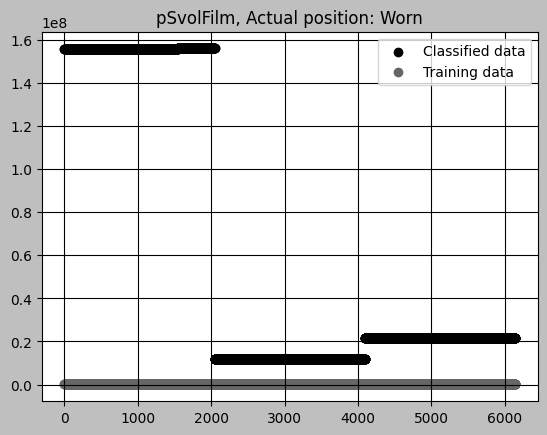

In [70]:
plt.scatter(
    X_master_worn_drop_df.index,
    X_master_worn_drop_df["pSvolFilm::CTRL_Position_controller::Actual_position"],
)
plt.scatter(
    wornData.index, wornData[" pSvolFilm CTRL Position controller: Actual position"]
)
plt.title("pSvolFilm, Actual position: Worn")
plt.legend(["Classified data", "Training data"])
plt.grid()
plt.savefig(
    "/content/drive/MyDrive/1 Projects/#BacArbeit/fig/pSvolFilm_Actual_position_Worn.png"
)
plt.show()

## pSvolFilm, Actual speed: New

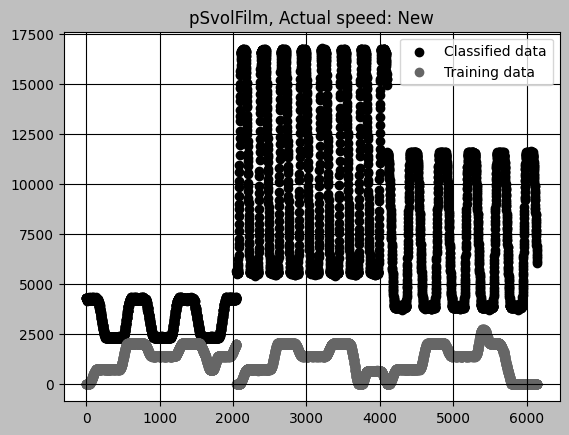

In [71]:
plt.scatter(
    X_master_new_drop_df.index,
    X_master_new_drop_df["pSvolFilm::CTRL_Position_controller::Actual_speed"],
)
plt.scatter(
    newData.index,
    newData[" pSvolFilm CTRL Position controller: Actual speed"],
)
plt.title("pSvolFilm, Actual speed: New")
plt.legend(["Classified data", "Training data"])
plt.grid()
plt.savefig(
    "/content/drive/MyDrive/1 Projects/#BacArbeit/fig/pSvolFilm_Actual_speed_New.png"
)
plt.show()

## pSvolFilm, Actual speed: Worn

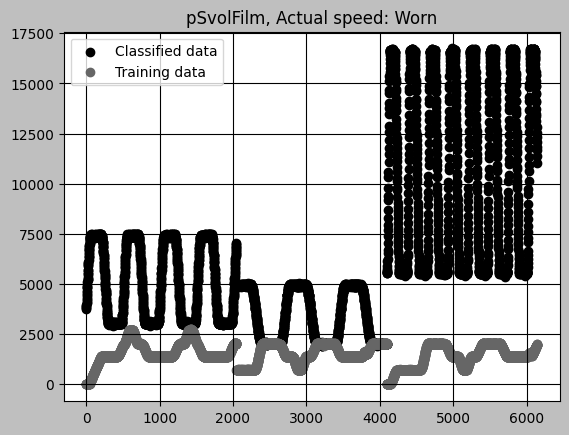

In [72]:
plt.scatter(
    X_master_worn_drop_df.index,
    X_master_worn_drop_df["pSvolFilm::CTRL_Position_controller::Actual_speed"],
)
plt.scatter(
    wornData.index,
    wornData[" pSvolFilm CTRL Position controller: Actual speed"],
)
plt.title("pSvolFilm, Actual speed: Worn")
plt.legend(["Classified data", "Training data"])
plt.grid()
plt.savefig(
    "/content/drive/MyDrive/1 Projects/#BacArbeit/fig/pSvolFilm_Actual_speed_Worn.png"
)
plt.show()

## pSvolFilm, Lag error: New

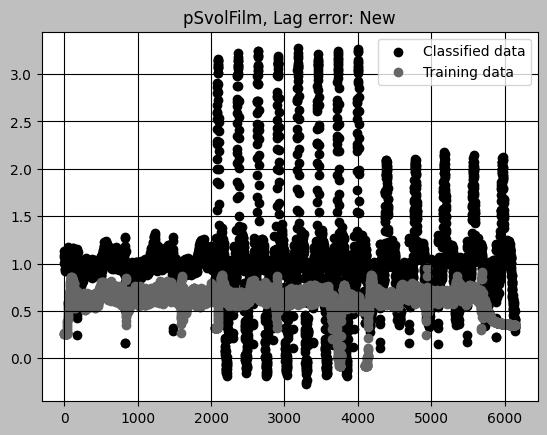

In [73]:
plt.scatter(
    X_master_new_drop_df.index,
    X_master_new_drop_df["pSvolFilm::CTRL_Position_controller::Lag_error"],
)
plt.scatter(
    newData.index,
    newData[" pSvolFilm CTRL Position controller: Lag error"],
)
plt.title("pSvolFilm, Lag error: New")
plt.legend(["Classified data", "Training data"])
plt.grid()
plt.savefig(
    "/content/drive/MyDrive/1 Projects/#BacArbeit/fig/pSvolFilm_Lag_error_New.png"
)
plt.show()

## pSvolFilm, Lag error: Worn

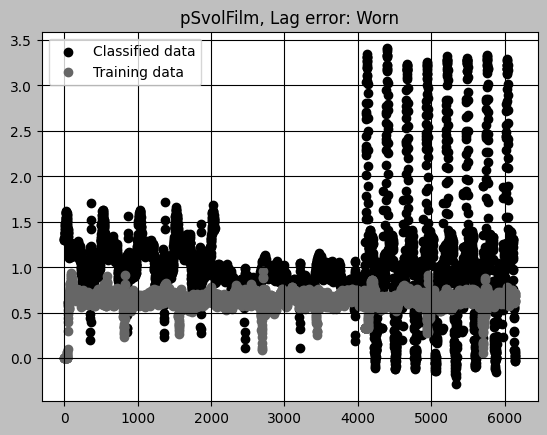

In [74]:
plt.scatter(
    X_master_worn_drop_df.index,
    X_master_worn_drop_df["pSvolFilm::CTRL_Position_controller::Lag_error"],
)
plt.scatter(
    wornData.index,
    wornData[" pSvolFilm CTRL Position controller: Lag error"],
)
plt.title("pSvolFilm, Lag error: Worn")
plt.legend(["Classified data", "Training data"])
plt.grid()
plt.savefig(
    "/content/drive/MyDrive/1 Projects/#BacArbeit/fig/pSvolFilm_Lag_error_Worn.png"
)
plt.show()

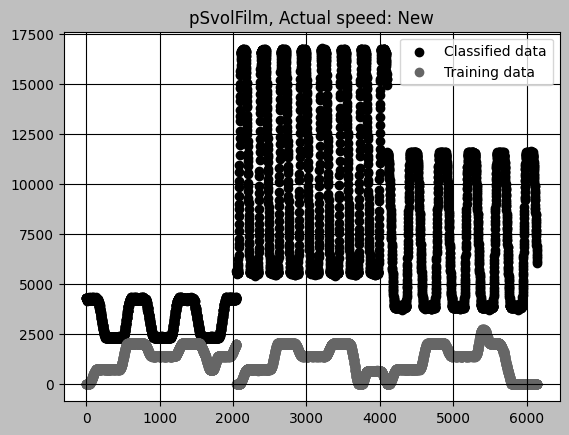

In [75]:
plt.scatter(
    X_master_new_drop_df.index,
    X_master_new_drop_df["pSvolFilm::CTRL_Position_controller::Actual_speed"],
)
plt.scatter(newData.index, newData[" pSvolFilm CTRL Position controller: Actual speed"])
plt.title("pSvolFilm, Actual speed: New")
plt.legend(["Classified data", "Training data"])
plt.grid()
plt.savefig(
    "/content/drive/MyDrive/1 Projects/#BacArbeit/fig/pSvolFilm_Actual_speed_New.png"
)
plt.show()

# Instanciating the model

## Pick a random sample from the test dataset.
Picking a Sample X, this is meant to be a worn blade.
The counterfactual engine should decide what to do to make it, according to the ML system, "new".

In [76]:
X_sample_new_df = X_master_new_df.iloc[877]
X_sample_new_df = X_sample_new_df.drop(labels=["Predicion", "Label", "Certitude Score"])
X_sample_new = X_sample_new_df.to_numpy()
X_sample_new

array([-1.99955530e-01, -9.12094000e-03, -2.03253980e+09,  4.63142383e+03,
        3.17171544e+08,  2.91689893e+03,  8.80867600e-01])

In [77]:
X_sample_worn_df = X_master_worn_df.iloc[881]
X_sample_worn_df = X_sample_worn_df.drop(
    labels=["Predicion", "Label", "Certitude Score"]
)
X_sample_worn = X_sample_worn_df.to_numpy()
X_sample_worn

array([-3.04677780e-01, -4.32291000e-02,  1.77226232e+08,  5.33866846e+03,
        1.56009418e+08,  2.98736743e+03,  1.02511537e+00])

A quick-output printer.

In [94]:
def print_out(model, explainer, sample):
    print("Does it have explainations: ", explainer.has_explanations())
    print()

    if explainer.has_explanations():
        print("Full explaination: ")
        print(explainer.full())
        print("'Human readable' explaination: ", explainer.human_readable()[0][0])
        print()

        for inex, _ in enumerate(explainer.perturbation_tracking):
            counterfactual = explainer.perturbation_tracking[inex]
            print("Sample to be explainied: ")
            print(sample)
            print("Counterfactual Sample: ")
            print(counterfactual)
            print()

        # counterfactual = explainer.perturbation_tracking[0]
        # print("Sample to be explainied: ")
        # print(sample)
        # print("Counterfactual Sample: ")
        # print(counterfactual)
        # print()

        print(
            "Class Predicion of Sample: ", model.predict(X_sample_new, verbose=0)[0][0]
        )
        print(
            "Class Prediction of counterfactual Sample: ",
            model.predict(counterfactual, verbose=0)[0][0],
        )
    else:
        print("No explainations at hand.")

## Instantiating the Tabular Simple Pertubation Proxy

In [79]:
proxy_simpleScore = tabular_counterfactual.TabularSimplePertubation(clas_model)
explainer_simpleScore = SequenceExplainer(GreedySearch(proxy_simpleScore, iterations=8))

### Explain the Sample with Tabular Simple Pertubation, with a sample of the state "new"

In [95]:
%%time
tab_explanations = explainer_simpleScore.explain(X_sample_new)
print_out(clas_model, tab_explanations, X_sample_new)

Does it have explainations:  True

Full explaination: 
[([(2, -2032539796.0)], array([[1.]], dtype=float32))]
'Human readable' explaination:  -2032539796.0

Sample to be explainied: 
[-1.99955530e-01 -9.12094000e-03 -2.03253980e+09  4.63142383e+03
  3.17171544e+08  2.91689893e+03  8.80867600e-01]
Counterfactual Sample: 
[-1.99955530e-01 -9.12094000e-03  0.00000000e+00  4.63142383e+03
  3.17171544e+08  2.91689893e+03  8.80867600e-01]

Class Predicion of Sample:  0.0
Class Prediction of counterfactual Sample:  1.0
CPU times: user 3.72 s, sys: 100 ms, total: 3.82 s
Wall time: 3.87 s


### Explain the Sample with Tabular Simple Pertubation, with a sample of the state "worn"

In [81]:
%%time
tab_explanations_worn = explainer_simpleScore.explain(X_sample_worn)
print_out(clas_model, tab_explanations_worn, X_sample_worn)

Does it have explainations:  False

No explainations at hand.
CPU times: user 4.69 s, sys: 67.3 ms, total: 4.76 s
Wall time: 5.01 s


## Instantiating the Tabular Mean Pertubation Proxy

In [82]:
proxy_SimpleMean = tabular_counterfactual.TabularMeanPertubation(clas_model, X_train)
explainer_SimpleMean = SequenceExplainer(GreedySearch(proxy_SimpleMean))

### Explain the Sample with Tabular Mean Pertubation, with a sample of the state "new"

In [83]:
%%time
tab_explanations_mean = explainer_SimpleMean.explain(X_sample_new)
print_out(clas_model, tab_explanations_mean, X_sample_new)

Does it have explainations:  True

Full explaination: 
[([(2, -2032539796.0)], array([[1.]], dtype=float32))]
'Human readable' explaination:  -2032539796.0

Sample to be explainied: 
[-1.99955530e-01 -9.12094000e-03 -2.03253980e+09  4.63142383e+03
  3.17171544e+08  2.91689893e+03  8.80867600e-01]
Counterfactual Sample: 
[-1.99955530e-01 -9.12094000e-03 -8.35660580e+05  4.63142383e+03
  3.17171544e+08  2.91689893e+03  8.80867600e-01]

Class Predicion of Sample:  0.0
Class Prediction of counterfactual Sample:  1.0
CPU times: user 1.35 s, sys: 20.7 ms, total: 1.37 s
Wall time: 1.38 s


### Explain the Sample with Tabular Mean Pertubation, with a sample of the state "worn"

In [84]:
%%time
tab_explanations_mean_worn = explainer_SimpleMean.explain(X_sample_worn)
print_out(clas_model, tab_explanations_mean_worn, X_sample_worn)

Does it have explainations:  False

No explainations at hand.
CPU times: user 1.31 s, sys: 22.3 ms, total: 1.33 s
Wall time: 1.34 s


## Instanciating the Tabular Median Pertubation Proxy

In [85]:
proxy_SimpleMedian = tabular_counterfactual.TabularMedianPertubation(
    clas_model, X_train
)
explainer_SimpleMedian = SequenceExplainer(GreedySearch(proxy_SimpleMedian))

### Explain the Sample with Tabular Median Pertubation, with a sample of the state "new"

In [86]:
%%time
tab_explanations_median = explainer_SimpleMedian.explain(X_sample_new)
print_out(clas_model, tab_explanations_median, X_sample_new)

Does it have explainations:  True

Full explaination: 
[([(2, -2032539796.0)], array([[1.]], dtype=float32))]
'Human readable' explaination:  -2032539796.0

Sample to be explainied: 
[-1.99955530e-01 -9.12094000e-03 -2.03253980e+09  4.63142383e+03
  3.17171544e+08  2.91689893e+03  8.80867600e-01]
Counterfactual Sample: 
[-1.99955530e-01 -9.12094000e-03 -8.38814500e+05  4.63142383e+03
  3.17171544e+08  2.91689893e+03  8.80867600e-01]

Class Predicion of Sample:  0.0
Class Prediction of counterfactual Sample:  1.0
CPU times: user 1.32 s, sys: 20.1 ms, total: 1.34 s
Wall time: 1.34 s


### Explain the Sample with Tabular Median Pertubation, with a sample of the state "worn"

In [87]:
%%time
tab_explanations_median_worn = explainer_SimpleMedian.explain(X_sample_worn)
print_out(clas_model, tab_explanations_median_worn, X_sample_worn)

Does it have explainations:  False

No explainations at hand.
CPU times: user 1.32 s, sys: 25.3 ms, total: 1.34 s
Wall time: 1.33 s


## Instanciating of the Tabular Random Uniform Pertubation Proxy

In [88]:
proxy_RandomUniform = tabular_counterfactual.TabularRandomUniformPertubation(
    clas_model, X_train
)
explainer_RandomUniform = SequenceExplainer(
    GreedySearch(proxy_RandomUniform, iterations=8)
)

### Explain the Sample with Random Uniform Pertubation, with a sample of the state "new"

In [89]:
%%time
tab_explanations_uniform = explainer_RandomUniform.explain(X_sample_new)
print_out(clas_model, tab_explanations_uniform, X_sample_new)

Does it have explainations:  True

Full explaination: 
[([(2, -2032539796.0)], array([[1.]], dtype=float32))]
'Human readable' explaination:  -2032539796.0

Sample to be explainied: 
[-1.99955530e-01 -9.12094000e-03 -2.03253980e+09  4.63142383e+03
  3.17171544e+08  2.91689893e+03  8.80867600e-01]
Counterfactual Sample: 
[-1.99955530e-01 -9.12094000e-03 -8.38173177e+05  4.63142383e+03
  3.17171544e+08  2.91689893e+03  8.80867600e-01]

Class Predicion of Sample:  0.0
Class Prediction of counterfactual Sample:  1.0
CPU times: user 3.82 s, sys: 62.1 ms, total: 3.88 s
Wall time: 3.99 s


### Explain the Sample with Random Uniform Pertubation, with a sample of the state "worn"

In [98]:
%%time
tab_explanations_uniform_worn = explainer_RandomUniform.explain(X_sample_worn)
print_out(clas_model, tab_explanations_uniform_worn, X_sample_worn)
print()

Does it have explainations:  True

Full explaination: 
[([(2, 177226232.0), (4, 156009418.0)], array([[0.]], dtype=float32))]
'Human readable' explaination:  177226232.0

Sample to be explainied: 
[-3.04677780e-01 -4.32291000e-02  1.77226232e+08  5.33866846e+03
  1.56009418e+08  2.98736743e+03  1.02511537e+00]
Counterfactual Sample: 
[-3.04677780e-01 -4.32291000e-02 -8.34721889e+05  5.33866846e+03
  3.37211185e+04  2.98736743e+03  1.02511537e+00]

Class Predicion of Sample:  0.0
Class Prediction of counterfactual Sample:  0.26722762

CPU times: user 4.61 s, sys: 75.9 ms, total: 4.68 s
Wall time: 5.28 s


## Instanciating of the Tabular Random Normal Pertubation Proxy

In [91]:
proxy_RandomNormal = tabular_counterfactual.TabularRandomNormalPertubation(
    clas_model, X_train
)
explainer_RandomNormal = SequenceExplainer(GreedySearch(proxy_RandomNormal))

### Explain the Sample with Random Normal Pertubation, with a sample of the state "new"

In [92]:
%%time
tab_explanations_normal = explainer_RandomNormal.explain(X_sample_new)
print_out(clas_model, tab_explanations_normal, X_sample_new)

Does it have explainations:  True

Full explaination: 
[([(2, -2032539796.0)], array([[1.]], dtype=float32))]
'Human readable' explaination:  -2032539796.0

Sample to be explainied: 
[-1.99955530e-01 -9.12094000e-03 -2.03253980e+09  4.63142383e+03
  3.17171544e+08  2.91689893e+03  8.80867600e-01]
Counterfactual Sample: 
[-1.99955530e-01 -9.12094000e-03 -8.35660580e+05  4.63142383e+03
  3.17171544e+08  2.91689893e+03  8.80867600e-01]

Class Predicion of Sample:  0.0
Class Prediction of counterfactual Sample:  1.0
CPU times: user 1.31 s, sys: 21.8 ms, total: 1.33 s
Wall time: 1.32 s


### Explain the Sample with Random Normal Pertubation, with a sample of the state "worn"

In [93]:
%%time
tab_explanations_normal_worn = explainer_RandomNormal.explain(X_sample_worn)
print_out(clas_model, tab_explanations_normal_worn, X_sample_worn)
print()

Does it have explainations:  False

No explainations at hand.

CPU times: user 1.29 s, sys: 33.4 ms, total: 1.32 s
Wall time: 1.3 s
